In [93]:
# Setup environment to load precomputed embeddings
import os, sys, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Add parent directory to sys.path
notebook_dir = Path().resolve()
project_dir = notebook_dir.parent if notebook_dir.name == 'notebooks' else notebook_dir
sys.path.insert(0, str(project_dir))

# Set paths
data_dir = project_dir / 'data'
embeddings_dir = data_dir / 'embeddings'
analysis_dir = data_dir / 'analysis' / 'locus_embeddings'

def load_embeddings(locus, class_type):
    embeddings_file = analysis_dir / class_type / 'embeddings' / f"hla_{locus}_embeddings.pkl"
    if not embeddings_file.exists():
        print(f"File {embeddings_file} not found. Run the analysis script first.")
        return None
    with open(embeddings_file, 'rb') as f:
        embeddings = pickle.load(f)
    print(f"Loaded {len(embeddings)} embeddings for HLA-{locus}")
    return embeddings


# B Locus Clustering Analysis

This notebook encodes the alleles at the B locus, performs clustering on the embeddings, and compares the cluster labels to the serological groupings (e.g. B*01, B*02, etc.).

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Attempt to load precomputed embeddings for B locus
embeddings = load_embeddings('B', 'class1')
if embeddings is None:
    # Precomputed embeddings not found; fall back to encoding sequences
    allele_file = 'data/raw/fasta/B_prot.fasta'
    with open(allele_file, 'r') as f:
        sequences = f.read().splitlines()
    from src.models.protbert import encode_sequences  # Ensure this function exists
    embeddings = encode_sequences(sequences)
if embeddings is not None and embeddings:
    # Show some basic stats
    allele = list(embeddings.keys())[0]
    embedding = embeddings[allele]
    print(f"Sample allele: {allele}")
    print(f"Embedding shape: {embedding.shape}")
    print(f"First 5 dimensions: {embedding[:5]}")

Loaded 6526 embeddings for HLA-B
Sample allele: B*07:02
Embedding shape: (1024,)
First 5 dimensions: [ 0.22962688  0.05856375 -0.00037082 -0.17931563  0.10208432]


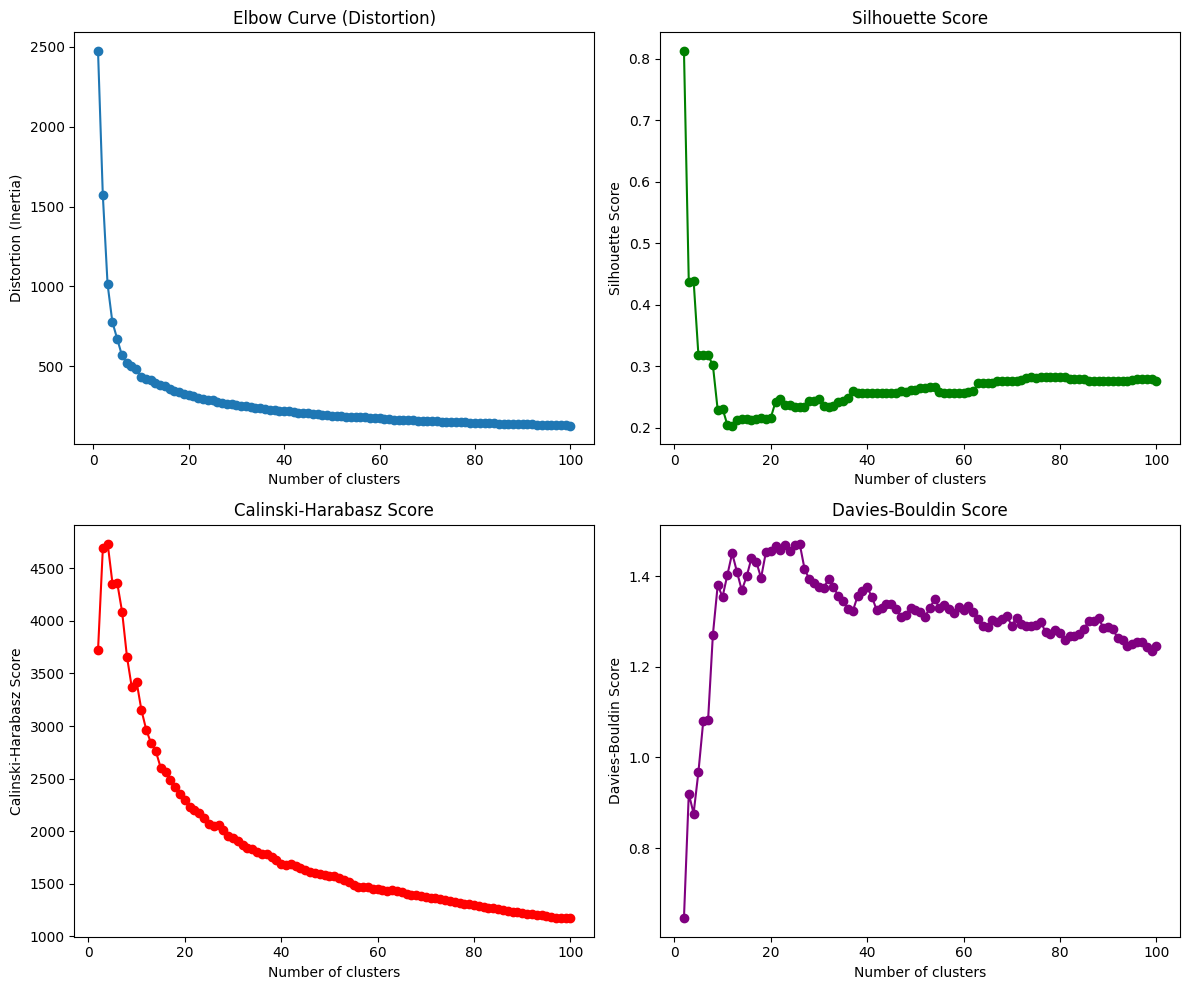

Optimal number of clusters based on silhouette score: 2


In [95]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

def cluster_embeddings(embeddings, max_clusters=36):
    # Convert embeddings to array
    X = np.array(list(embeddings.values()))

    distortions = []
    silhouette_scores = []
    calinski_scores = []
    davies_scores = []

    # Loop over possible number of clusters from 1 to max_clusters
    for i in range(1, max_clusters+1):
        kmeans = KMeans(n_clusters=i, random_state=0).fit(X)
        distortions.append(kmeans.inertia_)
        if i > 1:
            labels = kmeans.labels_
            silhouette = silhouette_score(X, labels)
            calinski = calinski_harabasz_score(X, labels)
            davies = davies_bouldin_score(X, labels)
            silhouette_scores.append(silhouette)
            calinski_scores.append(calinski)
            davies_scores.append(davies)
        else:
            # For 1 cluster these metrics are undefined; insert NaN for alignment.
            silhouette_scores.append(np.nan)
            calinski_scores.append(np.nan)
            davies_scores.append(np.nan)

    cluster_range = range(1, max_clusters+1)
    # Metrics computed for cluster counts from 2 to max_clusters (ignoring cluster==1 for non-inertia metrics)
    cluster_range_metrics = range(2, max_clusters+1)

    # Plot metrics in a grid of subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Elbow Curve (Distortion/Inertia)
    axes[0, 0].plot(cluster_range, distortions, marker='o')
    axes[0, 0].set_title('Elbow Curve (Distortion)')
    axes[0, 0].set_xlabel('Number of clusters')
    axes[0, 0].set_ylabel('Distortion (Inertia)')

    # Silhouette Score
    axes[0, 1].plot(cluster_range_metrics, silhouette_scores[1:], marker='o', color='green')
    axes[0, 1].set_title('Silhouette Score')
    axes[0, 1].set_xlabel('Number of clusters')
    axes[0, 1].set_ylabel('Silhouette Score')

    # Calinski-Harabasz Score
    axes[1, 0].plot(cluster_range_metrics, calinski_scores[1:], marker='o', color='red')
    axes[1, 0].set_title('Calinski-Harabasz Score')
    axes[1, 0].set_xlabel('Number of clusters')
    axes[1, 0].set_ylabel('Calinski-Harabasz Score')

    # Davies-Bouldin Score (lower is better)
    axes[1, 1].plot(cluster_range_metrics, davies_scores[1:], marker='o', color='purple')
    axes[1, 1].set_title('Davies-Bouldin Score')
    axes[1, 1].set_xlabel('Number of clusters')
    axes[1, 1].set_ylabel('Davies-Bouldin Score')

    plt.tight_layout()
    plt.show()

    # Select optimal number of clusters based on maximum silhouette score (skip cluster 1)
    best_index = np.nanargmax(silhouette_scores[1:])
    optimal_clusters = best_index + 2  # +2 accounts for starting at 2 clusters
    print(f"Optimal number of clusters based on silhouette score: {optimal_clusters}")

    # Fit and return KMeans with the optimal number of clusters
    kmeans = KMeans(n_clusters=25, random_state=0).fit(X)
    return kmeans

# Cluster embeddings
kmeans = cluster_embeddings(embeddings, max_clusters=100)



[ 0  0  0 ... 24 16 16]
dict_keys(['B*07:02', 'B*07:03', 'B*07:04', 'B*07:05', 'B*07:06', 'B*07:07', 'B*07:08', 'B*07:09', 'B*07:10', 'B*07:11', 'B*07:12', 'B*07:13', 'B*07:14', 'B*07:15', 'B*07:16', 'B*07:17', 'B*07:18', 'B*07:19', 'B*07:20', 'B*07:21', 'B*07:22', 'B*07:23', 'B*07:24', 'B*07:25', 'B*07:26', 'B*07:27', 'B*07:28', 'B*07:29', 'B*07:30', 'B*07:31', 'B*07:32', 'B*07:33', 'B*07:34', 'B*07:35', 'B*07:36', 'B*07:37', 'B*07:38', 'B*07:39', 'B*07:40', 'B*07:41', 'B*07:42', 'B*07:43', 'B*07:44N', 'B*07:45', 'B*07:46', 'B*07:47', 'B*07:48', 'B*07:49N', 'B*07:50', 'B*07:51', 'B*07:52', 'B*07:53', 'B*07:54', 'B*07:55', 'B*07:56', 'B*07:57', 'B*07:58', 'B*07:59', 'B*07:60', 'B*07:61', 'B*07:62', 'B*07:63', 'B*07:64', 'B*07:65', 'B*07:66', 'B*07:67N', 'B*07:68', 'B*07:69', 'B*07:70', 'B*07:71', 'B*07:72', 'B*07:73', 'B*07:74', 'B*07:75', 'B*07:76', 'B*07:77', 'B*07:78', 'B*07:79', 'B*07:80', 'B*07:81', 'B*07:82', 'B*07:83', 'B*07:84', 'B*07:85', 'B*07:86', 'B*07:87', 'B*07:88', 'B*07

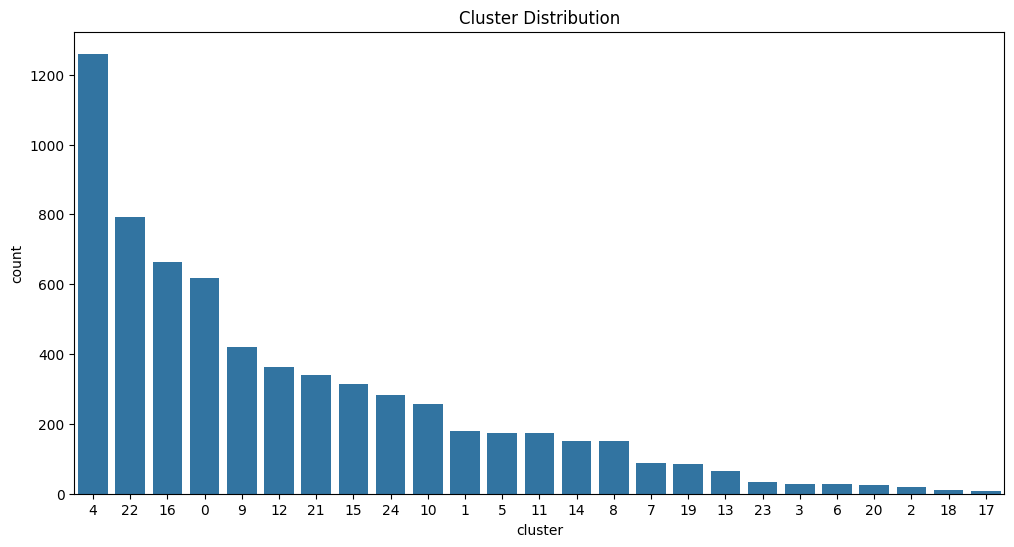

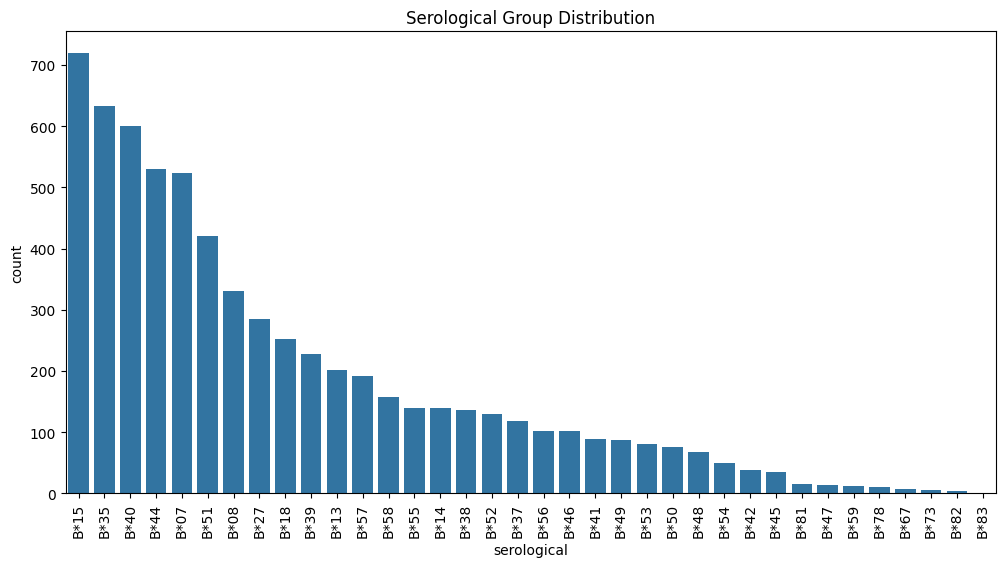

In [96]:
# Compare clusters to serological groups
all_alleles= embeddings.keys()
# Load serological name (name of allele upto first ':')
serological_mapping = all_alleles
serological_mapping = [allele.split(':')[0] for allele in all_alleles]
# Get cluster labels
cluster_labels = kmeans.labels_
print(cluster_labels)
print(all_alleles)
print(serological_mapping)

# Create a DataFrame with allele, serological group, and cluster label
df = pd.DataFrame({'allele': all_alleles, 'serological': serological_mapping, 'cluster': cluster_labels})
df = df.sort_values('cluster')

# Plot cluster distribution
plt.figure(figsize=(12, 6))
# sort by count
sns.countplot(x='cluster', data=df, order=df['cluster'].value_counts().index)
plt.title('Cluster Distribution')
plt.show()

# Plot serological group distribution
plt.figure(figsize=(12, 6))
# labels should be vertical
plt.xticks(rotation=90)
# sort by count
sns.countplot(x='serological', data=df, order=df['serological'].value_counts().index)
plt.title('Serological Group Distribution')
plt.show()


In [97]:
# cross tabulation of serological group and cluster
ct = pd.crosstab(df['serological'], df['cluster'])

# print the crosstab
ct

cluster,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
serological,,,,,,,,,,,,,,,,,,,,,
B*07,263,0,1,2,2,0,4,6,2,2,...,1,8,0,2,1,1,20,5,4,5
B*08,2,0,0,2,0,0,2,0,0,0,...,4,0,0,0,0,2,0,186,2,1
B*13,1,10,1,1,36,3,1,0,0,25,...,1,67,0,0,2,0,26,1,0,20
B*14,11,0,1,0,0,0,1,2,8,0,...,24,0,0,2,0,0,0,65,1,7
B*15,118,2,1,2,255,10,2,21,0,88,...,9,36,1,1,0,2,66,2,6,6
B*18,6,0,1,1,0,0,1,1,0,0,...,85,5,0,0,0,1,0,131,1,3
B*27,0,0,1,1,0,0,4,1,85,0,...,1,13,0,0,0,3,0,10,1,5
B*35,6,2,2,1,316,2,1,5,0,150,...,2,38,2,0,2,2,43,2,2,36
B*37,0,0,1,2,0,0,1,0,36,0,...,1,2,0,0,0,1,0,4,0,4


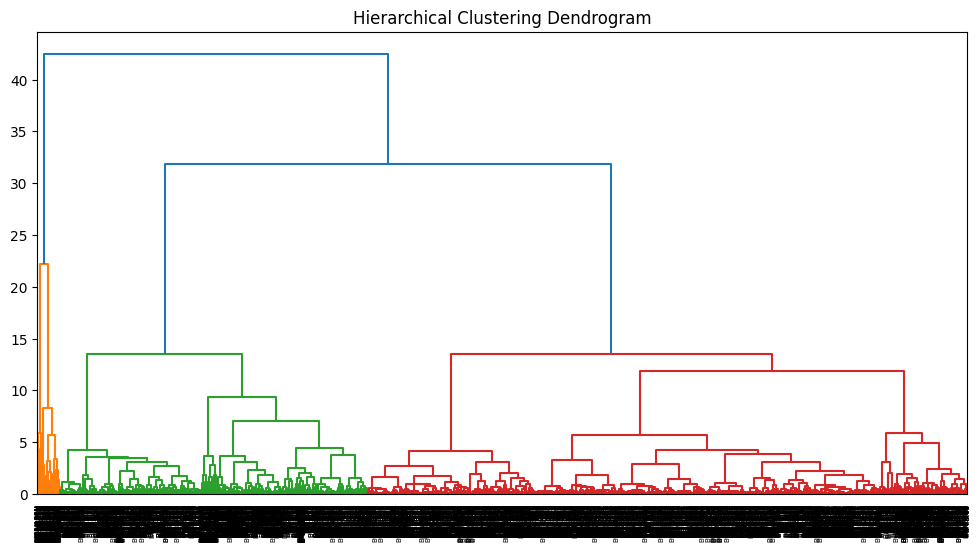

In [102]:
# hierarchical clustering
from scipy.cluster.hierarchy import linkage, dendrogram
# Compute the distance matrix
X = np.array(list(embeddings.values()))
Z = linkage(X, method='ward')
# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(Z, labels=list(embeddings.keys()), orientation='top', leaf_rotation=90)
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

In [99]:
import numpy as np
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, confusion_matrix

# Example cluster labels from unsupervised clustering and true serological labels
cluster_labels = df['cluster'].values
true_labels    = df['serological'].values
# convert true lables to integers
true_labels = pd.Categorical(true_labels).codes

# Compute Adjusted Rand Index (ARI)
ari = adjusted_rand_score(true_labels, cluster_labels)
print(f"Adjusted Rand Index (ARI): {ari:.4f}")

# Compute Normalized Mutual Information (NMI)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")

# Create a contingency table (confusion matrix)
contingency = confusion_matrix(true_labels, cluster_labels)
print("Contingency Table:")
print(contingency)




Adjusted Rand Index (ARI): 0.1556
Normalized Mutual Information (NMI): 0.3730
Contingency Table:
[[263   0   1 ...   0   0   0]
 [  2   0   0 ...   0   0   0]
 [  1  10   1 ...   0   0   0]
 ...
 [  1   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


In [100]:
import numpy as np
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix

def clustering_accuracy(true_labels, cluster_labels):
    """
    Compute clustering accuracy using the Hungarian algorithm for optimal label mapping.

    Parameters:
        true_labels (np.ndarray): Ground truth class labels.
        cluster_labels (np.ndarray): Predicted cluster labels from unsupervised clustering.

    Returns:
        float: Clustering accuracy as the proportion of correctly mapped labels.
    
    Explanation:
    ------------
    1. A confusion matrix (or contingency table) is computed where each element [i, j]
       represents the number of samples with true label i assigned to cluster j.
    2. The Hungarian algorithm (a.k.a. linear sum assignment) is applied on the negative
       of this matrix to find an assignment that maximizes the number of correctly matched labels.
       Since `linear_sum_assignment` minimizes cost, negating the matrix converts our maximization problem.
    3. The sum of the values corresponding to the optimal assignment is divided by the total
       number of samples to obtain the accuracy.
    """
    # Compute the contingency table between true and predicted labels
    cont_matrix = confusion_matrix(true_labels, cluster_labels)
    
    # Apply the Hungarian algorithm (linear_sum_assignment) on the negated contingency table.
    # This finds the optimal assignment that maximizes the number of matches.
    row_ind, col_ind = linear_sum_assignment(-cont_matrix)
    
    # Sum the counts from the contingency table for the optimal assignment
    total_correct = cont_matrix[row_ind, col_ind].sum()
    
    # Calculate the overall clustering accuracy
    accuracy = total_correct / np.sum(cont_matrix)
    return accuracy

# Example usage of the Hungarian algorithm for clustering accuracy:
# Example ground truth labels (serological labels)
true_labels = df['serological'].values
# Example clustering labels (obtained from an unsupervised clustering algorithm)
cluster_labels = df['cluster'].values
# convert true lables to integers
true_labels = pd.Categorical(true_labels).codes

# Compute the clustering accuracy using the Hungarian algorithm
acc = clustering_accuracy(true_labels, cluster_labels)
print(f"Clustering Accuracy (Optimal Assignment): {acc:.4f}")


Clustering Accuracy (Optimal Assignment): 0.2702


In [101]:
df.to_csv('clustered_alleles.csv', index=False)